<a href="https://colab.research.google.com/github/cr21/ImageSegmentation/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Math functions
# https://en.wikipedia.org/wiki/Generative_adversarial_network
import math
# Image related function from python image library
from PIL import Image, ImageDraw
from PIL import ImagePath
# pandas for data processing
import pandas as pd
# operating system api
import os
from os import path

from os import listdir
from os.path import isfile, join
# to monitor progress of iteration
from tqdm import tqdm
# json data processing
import json
# opencv library version 2
import cv2
# numpy for numerical processing of tensor
import numpy as np
# plotting library
import matplotlib.pyplot as plt
# urllib to get data from url
import urllib
pd.options.display.max_colwidth =1000
# tensor flow 
import tensorflow as tf
# tf.enable_eager_execution()

# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras.layers import Flatten
# split train and test data
from sklearn.model_selection import train_test_split


In [4]:
os.chdir('/content/drive/MyDrive/Dataset/TrafficData/')

In [5]:
# https://www.jeremyjordan.me/semantic-segmentation/#advanced_unet

In [5]:
ls

data/        preprocessed_data.csv     uniquelabels.txt
data_df.csv  preprocessed_data.gsheet  uniqueLabels.txt


In [6]:
#  get preprocessed Images
preprocessed_data = pd.read_csv("preprocessed_data.csv")
preprocessed_data.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [7]:
X_train, X_test = train_test_split(preprocessed_data, test_size=0.20, random_state=21)

In [8]:
print(f"X_train Data shape {X_train.shape}")
print(f"X_test Data shape {X_test.shape}")

X_train Data shape (3206, 3)
X_test Data shape (802, 3)


In [9]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
classes = list(set([filler for filler in label_clr.values()]))

In [10]:
def normalize_image(mask):
    mask = mask/255
    return mask

In [11]:
class Dataset:

    """
      Dataset class This class is useful for data preprocessing and getting items for Data Loader
    """
    

    def __init__(self, data_frame, width, height, classes):
        """
          Initialize the instance variable of class.

          Parameters : 
                data_frame  pandas.DataFrame -> columns : ["Image","Json","mask"]
                width   width of input image
                height  height of input image
                classes : number of output channels we have in our problem and corosponding filler value 
              
        """
        
        self.width  = width
        self.height = height
        self.imagePath = list(data_frame["image"])
        self.maskPath = list(data_frame["mask"])
        self.classValues = classes
    
    def __getitem__(self, index):
      """
      Function to get image and output mask at perticular index
      we can also use any augmentation technique here

      Parameters:
        index (int) : index to fetch the data

      return (image, mask) tuple

      """
      # get and read image at index in image path
      image = cv2.imread(self.imagePath[index],cv2.IMREAD_UNCHANGED)
      # resize the image to match with input dimension
      image = cv2.resize(image, (self.width, self.height), interpolation = cv2.INTER_NEAREST)

      # get and read mask at index in mask path
      mask = cv2.imread(self.maskPath[index], cv2.IMREAD_UNCHANGED)
      # resize the mask to match with dimension
      mask  = cv2.resize(mask, (self.width, self.height), interpolation  = cv2.INTER_NEAREST)
      #  we have21 different objects so output channel will be 21
      # https://www.jeremyjordan.me/semantic-segmentation/#advanced_unet
      image_mask_with_outputchannel = [(mask == j) for j in self.classValues]
      image_mask_with_outputchannel = np.stack(image_mask_with_outputchannel, axis = -1).astype('float')
      
      # Augmentation examples code might not be perfect but you could do something similar
      #     a = np.random.uniform()
      #     if a<0.2:
      #         image = image
      #         image_mask = image_mask
      #     elif a<0.4:
      #         image = aug3.augment_image(image)
      #         image_mask = aug3.augment_image(image_mask)
      #     elif a<0.6:
      #         image = aug4.augment_image(image)
      #         image_mask = aug4.augment_image(image_mask)
      #     elif a<0.8:
      #         image = aug5.augment_image(image)
      #         image_mask = image_mask
      #     else:
      #         image = aug6.augment_image(image)
      #         image_mask = aug6.augment_image(image_mask)
              
      return image, image_mask_with_outputchannel
        
    def __len__(self):
        return len(self.imagePath)

In [12]:
class DataLoader(tf.keras.utils.Sequence):
  """
    Data Loader class to generate Batch from Dataset. This class implements tf.keras.utils.sequence instances

  """

  def __init__(self, dataset, batch_size = 1, shuffle = False):
    """
      initialize the parameters for the class.

      parameters :
        
        dataset : Entire Dataset
        batch_size = size of the batch we want to return
        shuffle : if True shuffle the data at the end of each epoch


    """

    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indices = np.arange(len(dataset))

  def __getitem__(self, idx):
    """
    
      Function to get the batch at index idx.
      This will get next avaialbel batch_size set of records
    
    """
    
    # generate the batch data
    # get the next start and End index
    startIndex = idx * self.batch_size
    endIndex = (idx +1)  * self.batch_size
    
    collection  = []
    #  get the  next batch from start to end index
    for j in range(startIndex, endIndex):
      collection.append(self.dataset[j])
    
      #  create a batch by appending ( original Image :( 1920 * 1080 * 3 ), Mask : (1920,1080,21))
      #   [
      #         ( (1920,1080,3), (1920,1080,21) )
      #         ( (1920,1080,3), (1920,1080,21) )
      #         ( (1920,1080,3), (1920,1080,21) )
      #         ( (1920,1080,3), (1920,1080,21) )
      # ]
      
      
    batch = [np.stack(samples, axis=0) for samples in zip(*collection)]
      
    return tuple(batch)

  def __len__(self):
    """
      Get the number of Batch : total number of batch in entire dataset

    """

    return len(self.indices) // self.batch_size

  def on_epoch_end(self):
    """
      Operation to perform at the end of each epoch

      We will shuffle the indices at the end of each epoch

    """
    if self.shuffle:
        self.indices = np.random.permutation(self.indices)


In [13]:
train_dataset = Dataset(X_train, 1920, 1080, classes)
test_dataset = Dataset(X_test, 1920, 1080, classes)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
test_dataloader = DataLoader(test_dataset,  batch_size = 8, shuffle = True)

# visualize  Images and Mask

In [15]:
randomImage, randomMask = train_dataset[50]


In [32]:
imagesTitle = ["OriginalImage","Mask[0:3]","Mask[3:6]","Mask[6:9]","Mask[9:12]","Mask[12:15]","Mask[15:18]","Mask[18:21]"]
images = []
images.append(randomImage)
# add channel 0: 3  from mask channel
images.append(randomMask[...,0:3].squeeze())
# add channel 3: 6  from mask channel
images.append(randomMask[...,3:6].squeeze())
# add channel 6: 9  from mask channel
images.append(randomMask[...,6:9].squeeze())
# add channel 9: 12  from mask channel
images.append(randomMask[...,9:12].squeeze())
# add channel 12 15 from mask channel
images.append(randomMask[...,12:15].squeeze())
# add channel 15 : 18 from mask channel
images.append(randomMask[...,15:18].squeeze())
# add channel 18: 21 from mask channel
images.append(randomMask[...,18:21].squeeze())

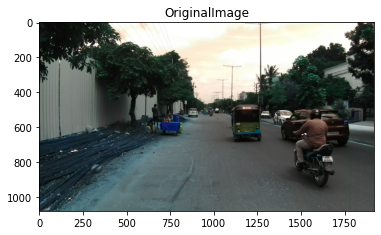

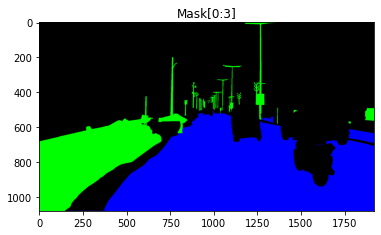

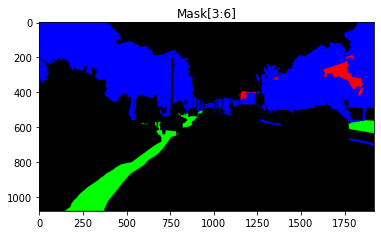

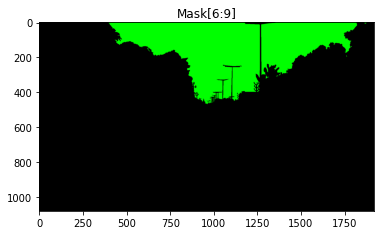

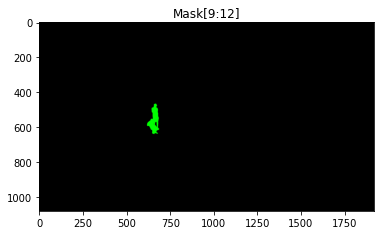

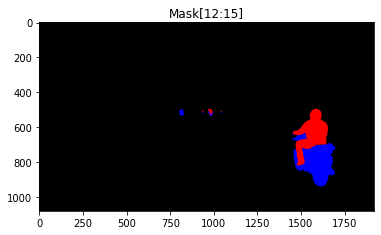

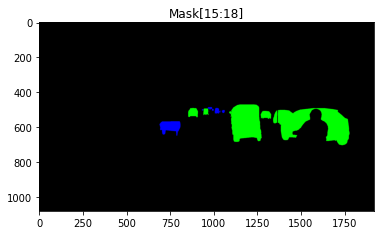

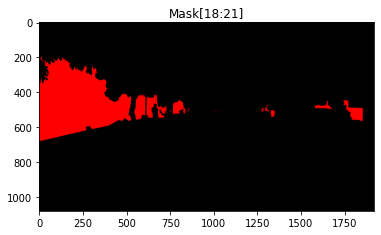

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def process(filename: str=None, title : str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    
    plt.figure()
    plt.title(title)
    plt.imshow(filename)

for idx,file in enumerate(images):
    process(file, imagesTitle[idx])